### Importing Libraries

In [1]:
!pip install deeprobust

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.generators.community import stochastic_block_model
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.community import random_partition_graph

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt



import random
from deeprobust.graph.data import Dataset

C:\Users\Mor\AppData\Local\Temp\ipykernel_13328\2103474578.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Real Datasets Import

In [3]:
dataset_name = 'cora' #other datatsets : 'citeseer' , 'polblogs' , 'acm'

In [4]:
ori_nodes = 2708 #original number of nodes.
## citeseer : 3312
## cora     : 2708
## polblogs : 1490
## acm      : 3025

In [5]:
data = Dataset(root='', name=dataset_name, setting='gcn',seed=10)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

A = np.array(adj.todense())
X=np.array(features.todense())
np.save("A.npy", A)
print(A)
#np.save("X.npy", X)
print(X)
import numpy as np
b=np.ones(ori_nodes)

z=A@b
D=np.diag(z)
L=D-A
print(L)



Loading cora dataset...
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[5. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 6. 0. 0.]
 [0. 0. 0. ... 0. 5. 0.]
 [0. 0. 0. ... 0. 0. 3.]]


In [6]:
U, S, Vh = np.linalg.svd(L, hermitian=True)
eigenvalues, eigenvectors = np.linalg.eig(L)
eigenvalues = np.real(eigenvalues)
#idx = np.argsort(S)[::-1]
#print(eigenvalues) 

k = 812 # Coarsened graph's number of nodes i.e. k = r*ori_nodes
U_k=U[:,k] # column on U 

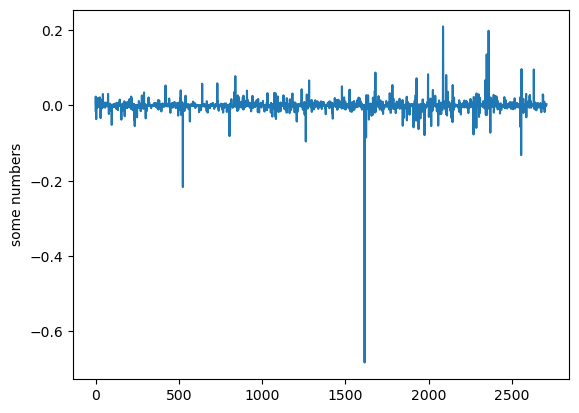

13.357363991197435


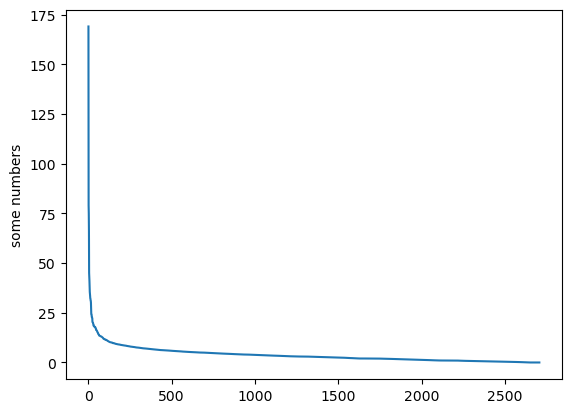

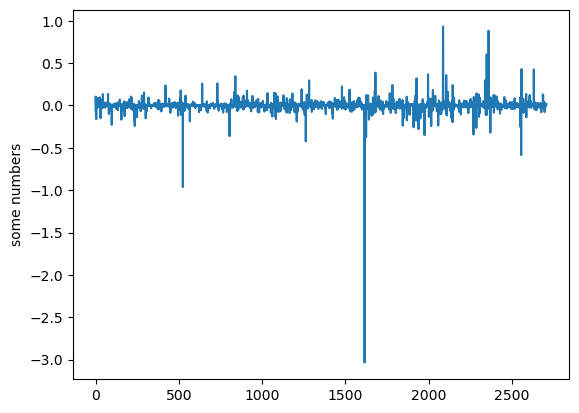

In [7]:
# Below shown for Cora.
k = 812 # Coarsened graph's number of nodes i.e. k = r*ori_nodes
U_k=U[:,k] # column on U 
# fig= plt.figure()

plt.plot(U_k)
plt.ylabel('some numbers')
plt.show()
print(S[70]) 
overall_loss = []
iterations = 10 # Number of iterations our objective function will run.
#print("Shape of the data matrix (p x n): ", X_now.shape)
plt.plot(S)
plt.ylabel('some numbers')
plt.show()
b=U_k@L

plt.plot(b)
plt.ylabel('some numbers')
plt.show()

In [8]:
class solver_v2:

  def __init__(self, X, k, lambda_param, beta_param, alpha_param, gamma_param):
    self.X = X
    self.p = X.shape[0]
    self.k = k
    self.n = X.shape[1]
    
    n = self.n
    k = self.k
    p = self.p
    
    self.thresh = 1e-10 # The 0-level

    # Basic initialization (Completely random)
    self.X_tilde = np.random.normal(0, 1, (k, n))
    
    self.C = np.random.normal(0,1,(p,k))
    self.C[self.C < self.thresh] = self.thresh
    
    self.w = np.random.normal(10, 1, (k*(k-1))//2)
    self.w[self.w < self.thresh] = self.thresh


    # Model Hyperparameters
    self.beta_param = beta_param
    self.alpha_param = alpha_param
    self.lambda_param = lambda_param
    self.gamma_param = gamma_param
    self.iters = 0
    self.lr0 = 1e-5

  def getLR(self):
    a = 0.99
    return self.lr0

  def calc_f(self):
    
    #w = self.w
    X_tilde = self.X_tilde
    beta_param = self.beta_param
    #Lw = self.L_operator(w)
    #L = np.load('L (5).npy')
    fw = 0

    fw += np.trace(X_tilde.T@self.C.T@L@self.C @X_tilde)
    # Added the tr(X.T L X) term
   # fw += ((beta_param*(np.linalg.norm(Lw)**2))/2)
    # Added the Frobbenius norm term
    J = np.outer(np.ones(self.k), np.ones(self.k))/self.k
    fw -= self.gamma_param*np.linalg.slogdet(self.C.T@L@self.C + J)[1]
    # Added the log_det term
    fw += (self.alpha_param/2)*(np.linalg.norm(np.subtract(self.X, np.dot(self.C, self.X_tilde))))**2
    # Added l2 norm || X - C*X_tilde ||
    fw += (self.lambda_param)/2*((np.linalg.norm(np.dot(self.C, np.ones((self.k, 1)))))**2)
    # Added L_1,2 norm || C ||
    return fw

  def update_X_tilde(self):
    #L = np.load('L (5).npy')
    L_tilde = self.C.T@L@self.C
    A = 2*L_tilde/(self.alpha_param)
    A = A + np.dot(self.C.T, self.C)
    b = np.dot(self.C.T, self.X)
    # Update 1
    self.X_tilde = np.linalg.pinv(A)@b

    # Update 2
    # lr = self.getLR()
    # self.X_tilde = self.X_tilde - lr*self.alpha_param*(A@self.X_tilde - b)

    # #new update:
    for i in range(len(self.X_tilde)):
      self.X_tilde[i] = (self.X_tilde[i]/(np.linalg.norm(self.X_tilde[i])))


    return None

  def grad_C(self):
    #L = np.load('L (5).npy')
    J = np.outer(np.ones(k), np.ones(k))/k
    v=np.linalg.pinv(self.C.T@L@self.C + J)
    gradC = np.zeros(self.C.shape)
    gradC += self.alpha_param*((self.C@self.X_tilde - self.X)@self.X_tilde.T)
    gradC += (self.lambda_param) * (np.abs(self.C) @ (np.ones((self.k, self.k))))
    gradC += -2*(self.gamma_param)*L@self.C@v
    gradC += 2*L@self.C@self.X_tilde@self.X_tilde.T
    
    return gradC

  def update_C(self, lr = None):
    if not lr:
      lr = 1/ (self.k)
    lr = self.getLR()
    C = self.C
    C = C - lr*self.grad_C()
    C[C<self.thresh] = self.thresh
    self.C = C
    C = self.C.copy()

    for i in range(len(C)):
      C[i] = C[i]/np.linalg.norm(C[i],1)

    self.C = C.copy()
    return None

  
  def fit(self, max_iters):
    ls = []
    MAX_ITER_INT = 100
    for i in tqdm(range(max_iters)):
      #for _ in range(MAX_ITER_INT):
        #self.update_w()
      for _ in range(MAX_ITER_INT):
        self.update_C(1/self.k)
      # for _ in range(MAX_ITER_INT):
      self.update_X_tilde()
      ls.append(self.calc_f())
      self.iters+=1
      #print(self.C@self.C.T)
      #print()

    return (self.C, self.X_tilde, ls )

  def New_fit(self):
    ls=[]
    MAX_ITER_INT = 100
    while(True):
      C_prev=self.C
      self.update_C(1/self.k)
      self.update_X_tilde()
      ls.append(self.calc_f())
      self.iters+=1
      if(np.linalg.norm(self.C-C_prev)<0.1): # we have set the threshold for stopping criteria as 0.1.
          return (self.C, self.X_tilde, ls )      
    return (self.C, self.X_tilde, ls )    

  def set_experiment(self, X, X_t):
    self.X = X
    self.X_tilde = X_t

In [28]:
class my_method:

  def __init__(self, X, k, lambda_param, beta_param, alpha_param, gamma_param,U_k_vecs):
    self.X = X
    self.p = X.shape[0]
    self.k = k
    self.n = X.shape[1]
    self.U_k=U_k_vecs
    
    n = self.n
    k = self.k
    p = self.p
    U_k =self.U_k
    
    self.thresh = 1e-10 # The 0-level

    # Basic initialization (Completely random)
    self.X_tilde = np.random.normal(0, 1, (k, n))
    
    self.C = np.random.normal(0,1,(p,k))
    self.C[self.C < self.thresh] = self.thresh
    
    self.w = np.random.normal(10, 1, (k*(k-1))//2)
    self.w[self.w < self.thresh] = self.thresh


    # Model Hyperparameters
    self.beta_param = beta_param
    self.alpha_param = alpha_param
    self.lambda_param = lambda_param
    self.gamma_param = gamma_param
    self.iters = 0
    self.lr0 = 1e-5

  def getLR(self):
    a = 0.99
    return self.lr0

  def calc_f(self):
    
    #w = self.w
    X_tilde = self.X_tilde
    U_k=self.U_k
    beta_param = self.beta_param
    #Lw = self.L_operator(w)
    #L = np.load('L (5).npy')
    fw = 0

    fw += np.trace(U_k@U_k.T@self.C@self.C.T)
    #fw += np.trace(X_tilde.T@self.C.T@L@self.C @X_tilde)
    fw += (self.alpha_param/2)*(np.linalg.norm(np.subtract(self.X, np.dot(self.C, self.X_tilde))))**2
    # Added l2 norm || X - C*X_tilde ||
    fw += (self.lambda_param)/2*((np.linalg.norm(np.dot(self.C, np.ones((self.k, 1)))))**2)
    # Added L_1,2 norm || C ||
    return fw

  def update_X_tilde(self):
    #L = np.load('L (5).npy')
    L_tilde = self.C.T@L@self.C
    A = 2*L_tilde/(self.alpha_param)
    A = A + np.dot(self.C.T, self.C)
    b = np.dot(self.C.T, self.X)
    
    # Update 1
    self.X_tilde = np.linalg.pinv(A)@b

    # Update 2
    # lr = self.getLR()
    # self.X_tilde = self.X_tilde - lr*self.alpha_param*(A@self.X_tilde - b)

    # #new update:
    for i in range(len(self.X_tilde)):
      self.X_tilde[i] = (self.X_tilde[i]/(np.linalg.norm(self.X_tilde[i])))


    return None

  def grad_C(self):
    #L = np.load('L (5).npy')
    J = np.outer(np.ones(k), np.ones(k))/k
    v=np.linalg.pinv(self.C.T@L@self.C + J)
    gradC = np.zeros(self.C.shape)
    gradC += self.alpha_param*((self.C@self.X_tilde - self.X)@self.X_tilde.T)
    gradC += (self.lambda_param) * (np.abs(self.C) @ (np.ones((self.k, self.k))))
    gradC += -2*self.U_k@self.U_k.T@self.C
    
    #gradC += -2*(self.gamma_param)*L@self.C@v
    #gradC += 2*L@self.C@self.X_tilde@self.X_tilde.T
    
    return gradC

  def update_C(self, lr = None):
    if not lr:
      lr = 1/ (self.k)
    lr = self.getLR()
    C = self.C
    C = C - lr*self.grad_C()
    C[C<self.thresh] = self.thresh
    self.C = C
    C = self.C.copy()

    for i in range(len(C)):
      C[i] = C[i]/np.linalg.norm(C[i],1)

    self.C = C.copy()
    return None

  
  def fit(self, max_iters):
    ls = []
    MAX_ITER_INT = 100
    for i in tqdm(range(max_iters)):
      #for _ in range(MAX_ITER_INT):
        #self.update_w()
      for _ in range(MAX_ITER_INT):
        self.update_C(1/self.k)
      # for _ in range(MAX_ITER_INT):
      self.update_X_tilde()
      ls.append(self.calc_f())
      self.iters+=1
      #print(self.C@self.C.T)
      #print()

    return (self.C, self.X_tilde, ls )

  def New_fit(self):
    ls=[]
    MAX_ITER_INT = 100
    while(True):
      C_prev=self.C
      self.update_C(1/self.k)
      self.update_X_tilde()
      ls.append(self.calc_f())
      self.iters+=1
      if(np.linalg.norm(self.C-C_prev)<0.1): # we have set the threshold for stopping criteria as 0.1.
          return (self.C, self.X_tilde, ls )      
    return (self.C, self.X_tilde, ls )    

  def set_experiment(self, X, X_t):
    self.X = X
    self.X_tilde = X_t

In [17]:
k = 812 # Coarsened graph's number of nodes i.e. k = r*ori_nodes

# Below shown for Cora.
k = 812 # Coarsened graph's number of nodes i.e. k = r*ori_nodes
overall_loss = []
overall_loss_my = []
iterations = 10 # Number of iterations our objective function will run.
#print("Shape of the data matrix (p x n): ", X_now.shape)

# Hyperparameters: lambda, beta, alpha, gamma
obj = solver_v2(X, k, 500, 0, 500, X.shape[1]/2) 
C_0, X_t_0, loss_ls = obj.fit(iterations)
overall_loss.extend(loss_ls)

100%|██████████| 10/10 [14:54<00:00, 89.43s/it]


In [49]:
U_k=U[:,:k] # column on U 


obj_my = my_method(X, k, 250, 0, 250, X.shape[1]/2,U_k) 
C_0_my, X_t_0_my, loss_ls_my = obj_my.fit(iterations)
overall_loss_my.extend(loss_ls_my)

100%|██████████| 10/10 [11:21<00:00, 68.20s/it]


 eigen_error 
(0.18856324076429706+0j)


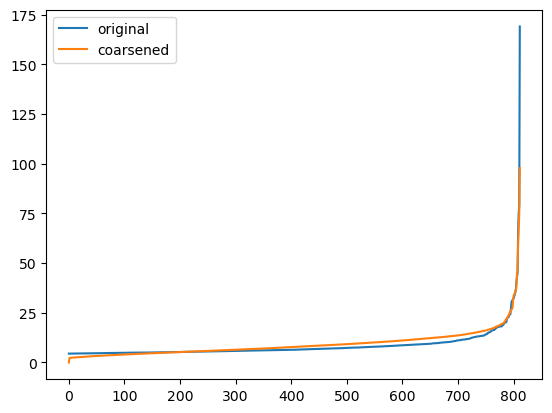

6582.814975660009
160963.0


In [45]:
eigen_values,eigenvectors=np.linalg.eig(L)

s=np.sort(eigen_values)

eigen_value,eigenvector=np.linalg.eig(C_0.T@L@C_0)

z=np.sort(eigen_value) 


s_new=s[-k:]
z_new=z[-k:]

temp=0
for j in range(len(s_new)):
  temp=temp+(abs(z_new[j]-s_new[j])/s_new[j])
eigenerror=temp/len(s_new)
print(" eigen_error ")
print(eigenerror)

plt.plot(s_new, label="original")
plt.plot(z_new, label="coarsened")
plt.legend()
plt.show()

print(np.trace(X_t_0.T@C_0.T@L@C_0@X_t_0))
print(np.trace(X.T@L@X))

 eigen_error 
(0.30588739372317936+0j)


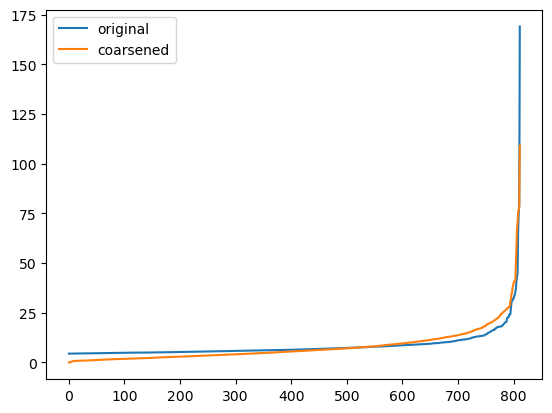

5722.55837148165
160963.0


In [48]:
eigen_values,eigenvectors=np.linalg.eig(L)

s=np.sort(eigen_values)

eigen_value_my,eigenvector_my=np.linalg.eig(C_0_my.T@L@C_0_my)

z=np.sort(eigen_value_my) 


s_new=s[-k:]
z_new=z[-k:]

temp=0
for j in range(len(s_new)):
  temp=temp+(abs(z_new[j]-s_new[j])/s_new[j])
eigenerror=temp/len(s_new)
print(" eigen_error ")
print(eigenerror)

plt.plot(s_new, label="original")
plt.plot(z_new, label="coarsened")
plt.legend()
plt.show()

print(np.trace(X_t_0_my.T@C_0_my.T@L@C_0_my@X_t_0_my))
print(np.trace(X.T@L@X))

In [37]:
P=np.linalg.pinv(C_0)
L_lift=P.T@C_0.T@L@C_0@P
LL=(L-L_lift)
np.log(pow(np.linalg.norm(LL),2))

11.396261429420928

In [43]:
P_my=np.linalg.pinv(C_0_my)
L_lift_my=P_my.T@C_0_my.T@L@C_0_my@P_my
LL_my=(L-L_lift_my)
np.log(pow(np.linalg.norm(LL_my),2))

11.621432188469537